- mu_I only zero for # e- = 0
- no frozen core approximation/pseudopotentials (pp only for pbc)
- h_core in code = e_kin + e_nuc_e


- N2 as reference system: E(\lambda) = diatomics from H2 to N2 (no basis set, core potential etc. problem)
- N2 from diatomics 3.56 Ha to low, N2 from APDFT implementation differs 230mH from N2 from diatomics

- N2 mean of lumo homo very close to N2 reference (coincidence, for qm9 molecule both are bad)

- deviation from true energy might be systematic -> could be corrected by using atomisation energies where energies of atoms are calculated from alchemy

### Test N2 from alchemy

- why is mean of lumo, homo better?
- how good are atomisation energies? (error canceling)
- how to calcs for unpaired electrons?

In [1]:
import numpy as np
import scipy as sc
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib
from pyscf.data import nist
import qml
from matplotlib import pyplot as plt

angstrom = 1 / 0.52917721067

In [2]:
def N2_diatomics(basis = 'def2-tzvp'):
    el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N']
    energies = []
    alchemical_potentials = []
    e_homos = []
    e_lumos = []
    for e in el:
        mol = pyscf.gto.Mole()
        mol.atom = f'{e} 0 0 0; {e} 0 0 3.5'
        mol.basis = basis
        mol.verbose = 0
        mol.build()
        calc = pyscf.scf.RHF(mol)
        calc.kernel()
        energies.append(calc.e_tot)
        dm1_ao = calc.make_rdm1()
        # get alchemical potential
        # Electronic EPN from electron density
        alch_pot_tmp = []
        for site in [0,1]:
            mol.set_rinv_orig_(mol.atom_coords()[site])
    #         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
            alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(alch_pot_tmp)

        # get ehomo
        idx_homo = np.where(calc.get_occ()>0)[0][-1]
        idx_lumo = idx_homo + 1
        calc.mo_energy.sort()
        e_homos.append(calc.mo_energy[idx_homo])
        e_lumos.append(calc.mo_energy[idx_lumo])
        
    alchemical_potentials.insert(0, [0.0, 0.0])
    alchemical_potentials = np.array(alchemical_potentials)*(-1)
    e_homos.insert(0, 0)
    e_homos = np.array(e_homos)
    e_lumos.insert(0, 0)
    e_lumos = np.array(e_lumos)
    
    return(alchemical_potentials, e_homos, e_lumos, calc.energy_nuc())

def N_atoms():
    el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O']
    energies = []
    alchemical_potentials = []
    e_homos = []
    e_lumos = []
    for e, Z in zip(el, np.arange(1,8)):
        mol = pyscf.gto.Mole()
        mol.atom = f'{e} 0 0 0'
        mol.basis = 'def2-tzvp'
        mol.verbose = 0
        mol.spin = Z%2
        mol.build()
        calc = pyscf.scf.RHF(mol)
        calc.kernel()
        energies.append(calc.e_tot)
        dm1_ao = calc.make_rdm1()
        # get alchemical potential
        # Electronic EPN from electron density
        alch_pot_tmp = []
        for site in [0]:
            mol.set_rinv_orig_(mol.atom_coords()[site])
    #         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
            alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(alch_pot_tmp)

        # get ehomo
        idx_homo = np.where(calc.get_occ()>0)[0][-1]
        idx_lumo = idx_homo + 1
        calc.mo_energy.sort()
        e_homos.append(calc.mo_energy[idx_homo])
        e_lumos.append(calc.mo_energy[idx_lumo])
        
    alchemical_potentials.insert(0, [0.0, 0.0])
    alchemical_potentials = np.array(alchemical_potentials)*(-1)
    e_homos.insert(0, 0)
    e_homos = np.array(e_homos)
    e_lumos.insert(0, 0)
    e_lumos = np.array(e_lumos)
    
    return(alchemical_potentials, e_homos, e_lumos, calc.energy_nuc())

def N2_APDFT(basis = 'def2-tzvp'):
    total_elec = 14
    # num_elecs = np.arange(15)
    num_elecs = [2, 4, 6, 8, 10, 12, 14]

    alchemical_potentials = []
    e_homos = []
    e_lumos = []

    for num_elec in num_elecs:
        lam_val = num_elec/total_elec

        mol = pyscf.gto.Mole()
        mol.atom = 'N 0 0 0; N 0 0 1.5'
        mol.basis = basis
        print(total_elec - num_elec)
        mol.charge = total_elec - num_elec
#         mol.spin = num_elec%2
        mol.verbose = 0
        mol.build()

        method = "HF"
        if method not in ["CCSD", "HF"]:
            raise NotImplementedError("Method %s not supported." % method)

        deltaZ = [-mol.charge/2, -mol.charge/2]
        includeonly = np.arange(len(mol.atom_coords()))


        def add_qmmm(calc, mol, deltaZ):
            mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()[includeonly]/ angstrom, deltaZ)

            def energy_nuc(self):
                q = mol.atom_charges().astype(np.float)
                q[includeonly] += deltaZ
                return mol.energy_nuc(q)

            mf.energy_nuc = energy_nuc.__get__(mf, mf.__class__)

            return mf

        if method == "HF":
            calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
            hfe = calc.kernel(verbose=0)
            dm1_ao = calc.make_rdm1()
            total_energy = calc.e_tot
        if method == "CCSD":
            calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
            hfe = calc.kernel(verbose=0)
            mycc = pyscf.cc.CCSD(calc).run()
            dm1 = mycc.make_rdm1()
            dm1_ao = np.einsum("pi,ij,qj->pq", calc.mo_coeff, dm1, calc.mo_coeff.conj())
            total_energy = mycc.e_tot

        # GRIDLESS, as things should be ############################
        # Total energy of SCF run

        print("TOTAL_ENERGY", total_energy)

        # Electronic EPN from electron density
        alch_pot_tmp = []
        for site in includeonly:
            mol.set_rinv_orig_(mol.atom_coords()[site])
    #         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
            alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(alch_pot_tmp)

        # energy of HOMO and LUMO
        nocc = int((total_elec - mol.charge)/2)
        e_homos.append(calc.mo_energy[nocc-1])
        e_lumos.append(calc.mo_energy[nocc])
        
    alchemical_potentials.insert(0, [0.0, 0.0])
    alchemical_potentials = np.array(alchemical_potentials)*(-1)
    e_homos.insert(0, 0)
    e_homos = np.array(e_homos)
    e_lumos.insert(0, 0)
    e_lumos = np.array(e_lumos)
        
    return(alchemical_potentials, e_homos, e_lumos, calc.energy_nuc())
    
def get_energy(lam_vals, alchemical_potentials, nuc_rep, e_homos, dZ, dN):
    mu_I = sc.integrate.simps(alchemical_potentials, lam_vals)
#     mu_I = np.trapz(alchemical_potentials, lam_vals)
    e_homo = np.trapz(e_homos, lam_vals)
    
    return(2*mu_I * dZ + e_homo*dN + nuc_rep)

### Referenz calculation

In [3]:
mol = pyscf.gto.Mole()
mol.atom = 'N 0 0 0; N 0 0 1.5'
mol.basis = 'def2-tzvp'
mol.build()
m = pyscf.scf.RHF(mol)
m.kernel()
e_ref_tzvp = m.e_tot

converged SCF energy = -108.706811596033


In [4]:
mol = pyscf.gto.Mole()
mol.atom = 'N 0 0 0; N 0 0 1.5'
mol.basis = 'def2-qzvp'
mol.build()
m = pyscf.scf.RHF(mol)
m.kernel()
e_ref_qzvp = m.e_tot

converged SCF energy = -108.711062429174


In [5]:
lam_vals = np.arange(0, 16, 2)/14
lam_vals

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        ])

#### influence of basis set size on energy
- difference between APDFT and diatomics shrinks for larger basis
- deviation from true energy becomes even larger (around 30 mHa) for diatomics but smaller for APDFT, however remains in the same order of magnitude (3.5 Ha)
- energy decreases for APDFT with larger basis set!? because alchemical potential decreases
- kink in plot of $E(\lambda)$ vs $\lambda$ does not disappear for diatomics but for APDFT it seems to be less strong (-> influence of basis set?)



In [6]:
ehomos_tzvp-ehomos_qzvp

NameError: name 'ehomos_tzvp' is not defined

In [7]:
# N2 from diatomics
alchemical_pots_tzvp, ehomos_tzvp, elumos_tzvp, e_nuc_tzvp = N2_diatomics('def2-tzvp')

alchemical_pots_qzvp, ehomos_qzvp, elumos_qzvp, e_nuc_qzvp = N2_diatomics('def2-qzvp')

energy_tzvp = get_energy(lam_vals, alchemical_pots_tzvp[:,0], e_nuc_tzvp, ehomos_tzvp , 7, 14)
energy_qzvp = get_energy(lam_vals, alchemical_pots_qzvp[:,0], e_nuc_qzvp, ehomos_qzvp , 7, 14)

In [8]:
energy_tzvp_simps = get_energy(lam_vals, alchemical_pots_tzvp[:,0], e_nuc_tzvp, ehomos_tzvp , 7, 14)
energy_qzvp_simps = get_energy(lam_vals, alchemical_pots_qzvp[:,0], e_nuc_qzvp, ehomos_qzvp , 7, 14)

In [9]:
# N2 from APDFT
alchemical_pots2_tzvp, ehomos2_tzvp, elumos2_tzvp, e_nuc2_tzvp = N2_APDFT('def2-tzvp')
alchemical_pots2_qzvp, ehomos2_qzvp, elumos2_qvzp, e_nuc2_qzvp = N2_APDFT('def2-qzvp')

12
TOTAL_ENERGY -1.001101419864852
10
TOTAL_ENERGY -5.6285244596173225
8
TOTAL_ENERGY -14.393211474040497
6
TOTAL_ENERGY -28.563023109075935
4
TOTAL_ENERGY -48.75621281463031
2
TOTAL_ENERGY -75.26768502575814
0
TOTAL_ENERGY -108.70681159603282
12
TOTAL_ENERGY -1.0023008366364254
10
TOTAL_ENERGY -5.703220593661493
8
TOTAL_ENERGY -14.654146155695019
6
TOTAL_ENERGY -28.968102569276297
4
TOTAL_ENERGY -48.891621151237985
2
TOTAL_ENERGY -75.34530512417336
0
TOTAL_ENERGY -108.71106242917378


In [10]:
energy2_tzvp = get_energy(lam_vals, alchemical_pots2_tzvp[:,0], e_nuc2_tzvp, ehomos2_tzvp , 7, 14)
energy2_qzvp = get_energy(lam_vals, alchemical_pots2_qzvp[:,0], e_nuc2_qzvp, ehomos2_qzvp , 7, 14)

In [11]:
energy2_tzvp_simps = get_energy(lam_vals, alchemical_pots2_tzvp[:,0], e_nuc2_tzvp, ehomos2_tzvp , 7, 14)
energy2_qzvp_simps = get_energy(lam_vals, alchemical_pots2_qzvp[:,0], e_nuc2_qzvp, ehomos2_qzvp , 7, 14)

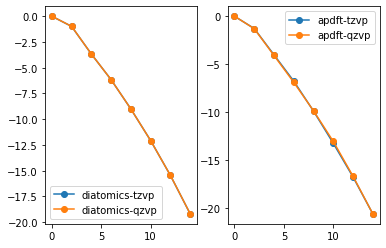

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].plot(np.arange(0, 16, 2), alchemical_pots_tzvp[:,0], '-o', label = 'diatomics-tzvp')
ax[0].plot(np.arange(0, 16, 2), alchemical_pots_qzvp[:,0], '-o', label = 'diatomics-qzvp')
# ax[0].plot(np.arange(0, 16, 2), alchemical_pots_qzvp[:,0]-alchemical_pots_tzvp[:,0], '-o', label = 'diatomics-qzvp')


ax[1].plot(np.arange(0, 16, 2), alchemical_pots2_tzvp[:,0], '-o', label = 'apdft-tzvp')
ax[1].plot(np.arange(0, 16, 2), alchemical_pots2_qzvp[:,0], '-o', label = 'apdft-qzvp')
ax[0].legend()
ax[1].legend()

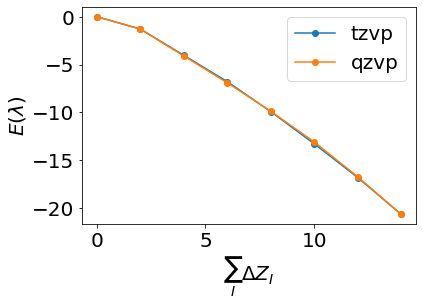

In [18]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

ax.plot(np.arange(0, 16, 2), alchemical_pots2_tzvp[:,0], '-o', label = 'tzvp')
ax.plot(np.arange(0, 16, 2), alchemical_pots2_qzvp[:,0], '-o', label = 'qzvp')
ax.set_xlabel('$\sum_I \Delta Z_I$')
ax.set_ylabel('$E(\lambda)$')
ax.legend()

In [14]:
print(f'energy-diatomics with tzvp {energy_tzvp} and diff to ref = {energy_tzvp-e_ref_tzvp}')
# -107.960473562694
print(f'energy-diatomics with qzvp {energy_qzvp} and diff to ref = {energy_qzvp-e_ref_qzvp}')

print(f'energy-apdft with tzvp {energy2_tzvp} and diff to ref = {energy2_tzvp-e_ref_tzvp}')
print(f'energy-apdft with qzvp {energy2_qzvp} and diff to ref = {energy2_qzvp-e_ref_qzvp}')

energy-diatomics with tzvp -110.76681549366738 and diff to ref = -2.0600038976346156
energy-diatomics with qzvp -110.75793472063539 and diff to ref = -2.046872291461682
energy-apdft with tzvp -112.07214691410269 and diff to ref = -3.365335318069924
energy-apdft with qzvp -111.85194899107012 and diff to ref = -3.1408865618964086


In [20]:
e_ref_qzvp

-108.71106242917371

In [ ]:
energy2_qzvp_simps - -112.29064735100559

In [ ]:
energy_qzvp_simps--112.30068728263183

In [ ]:
np.trapz(ehomos2_qzvp, lam_vals)*14

#### Integration of e_homo

In [ ]:
plt.plot(np.arange(0, 16, 2), ehomos_tzvp, '-o')
plt.plot(np.arange(0, 16, 2), ehomos_qzvp, '-o')

In [ ]:
lam_vals[1:]

In [ ]:
from ase.units import Bohr
d = 1.5/Bohr
1/d

In [ ]:
lam_vals = np.arange(8)*2/14

e_from_homo = get_atomic_energy(lam_vals, alchemical_pots[:,0], e_nuc/2, ehomos, 7, 7)*2
e_from_lumo = get_atomic_energy(lam_vals, alchemical_pots[:,0], e_nuc/2, elumos, 7, 7)*2

mean = (e_from_homo + e_from_lumo)/2

print(f'energy using homo = {e_from_homo}, delta E_ref = {e_from_homo - e_ref}')
print(f'energy using lumo = {e_from_lumo}, delta E_ref = {e_from_lumo - e_ref}')
print(f'energy using mean of homo and lumo = {mean}, delta E_ref = {mean - e_ref}')

### Atomisation energy

In [ ]:
N_atoms()

In [ ]:
el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N']
energies = []
alchemical_potentials = []
e_homos = []
e_lumos = []

mol = pyscf.gto.Mole()
mol.atom = f'li 0 0 0'
mol.basis = 'def2-tzvp'
mol.verbose = 0
mol.spin = 1
mol.build()
calc = pyscf.scf.RHF(mol)
calc.kernel()
energies.append(calc.e_tot)
dm1_ao = calc.make_rdm1()
# get alchemical potential
# Electronic EPN from electron density
alch_pot_tmp = []
mol.set_rinv_orig_(mol.atom_coords()[0])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())

# get ehomo
idx_homo = np.where(calc.get_occ()>0)[0][-1]
idx_lumo = idx_homo + 1
calc.mo_energy.sort()
e_homos.append(calc.mo_energy[idx_homo])
e_lumos.append(calc.mo_energy[idx_lumo])

In [ ]:
el = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N']
energies = []
alchemical_potentials = []
e_homos = []
e_lumos = []
for e in el:
    mol = pyscf.gto.Mole()
    mol.atom = f'{e} 0 0 0; {e} 0 0 1.5'
    mol.basis = 'def2-tzvp'
    mol.verbose = 0
    mol.build()
    calc = pyscf.scf.RHF(mol)
    calc.kernel()
    energies.append(calc.e_tot)
    dm1_ao = calc.make_rdm1()
    # get alchemical potential
    # Electronic EPN from electron density
    alch_pot_tmp = []
    for site in [0,1]:
        mol.set_rinv_orig_(mol.atom_coords()[site])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alch_pot_tmp.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
    alchemical_potentials.append(alch_pot_tmp)

    # get ehomo
    idx_homo = np.where(calc.get_occ()>0)[0][-1]
    idx_lumo = idx_homo + 1
    calc.mo_energy.sort()
    e_homos.append(calc.mo_energy[idx_homo])
    e_lumos.append(calc.mo_energy[idx_lumo])

In [ ]:
calc.get_occ()